In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from qudi_hira_analysis import DataHandler
import random

from typing import Tuple

import seaborn as sns

In [2]:
data_folder = Path("C://Data/)
figure_folder = Path("C://Data/figures")
measurement_folder = Path("20230703_TestRasterODMR")

In [3]:
dh = DataHandler(data_folder=data_folder, figure_folder=figure_folder, measurement_folder=measurement_folder, copy_measurement_folder_structure=False)

qudi_hira_analysis.data_handler :: INFO :: Data folder path is /Users/dineshpinto/PycharmProjects/qudi-hira-analysis/notebooks/Data/20230703_TestRasterODMR
qudi_hira_analysis.data_handler :: INFO :: Figure folder path is /Users/dineshpinto/PycharmProjects/qudi-hira-analysis/notebooks/Data/figures


In [4]:
measurement_str = "rasterodmr_linear_noise_factor_1e-02_32x32pixels"
odmr_measurements = dh.load_measurements(measurement_str=measurement_str)

In [5]:
odmr_measurements = dict(sorted(odmr_measurements.items()))

In [6]:
len(odmr_measurements)

1024

# Fit to single lorentzian and examine residuals

In [ ]:
def lorentzian_fitting(
    data: pd.DataFrame, 
    threshold_a: float,
    threshold_b: float
) -> Tuple[np.ndarray, np.ndarray, Model]:
    x_fit, y_fit, res = dh.fit(x="Freq(MHz)", y="Counts", fit_function=dh.fit_function.lorentzian, data=odmr.data)
    params = [
        Parameter(name="l0_center", value=res.best_values["center"]), 
        Parameter(name="l1_center", value=res.best_values["center"]),
        Parameter(name="l0_sigma", min=0.5, max=3),
        Parameter(name="l1_sigma", min=0.5, max=3),
    ]

    if res.rsquared < threshold_a:
        x_fit, y_fit, res = dh.fit(x="Freq(MHz)", y="Counts", fit_function=dh.fit_function.lorentziandouble, data=odmr.data)
        
        if res.rsquared < threshold_b:
            x_fit, y_fit, res = dh.fit(x="Freq(MHz)", y="Counts", fit_function=dh.fit_function.lorentziandouble, data=odmr.data, parameters=params)
            
    return x_fit, y_fit, res

def lorentzian_fitting_auto(data: pd.DataFrame, fit_function: FitMethodsAndEstimators) -> Tuple[np.ndarray, np.ndarray, Model]:
    x_fit1, y_fit1, res1 = dh.fit(x="Freq(MHz)", y="Counts", fit_function=dh.fit_function.lorentzian, data=odmr.data)
    center, sigma = res1.best_values["center"], res1.best_values["sigma"]
    params = [
        Parameter(name="l0_center", value=center),
        Parameter(name="l1_center", value=center)
    ]
    x_fit2, y_fit2, res2 = dh.fit(x="Freq(MHz)", y="Counts", fit_function=dh.fit_function.lorentziandouble, data=odmr.data, parameters=params)

    if res2.rsquared > res1.rsquared:
        return x_fit2, y_fit2, res2
    else:
        return x_fit1, y_fit1, res1

In [ ]:
r2s_single = np.ones(len(odmr_measurements)) * np.nan
r2s_double = np.ones(len(odmr_measurements)) * np.nan
r2s_params = np.ones(len(odmr_measurements)) * np.nan

thresh_a = 0.97
thresh_b = 0.90

assert thresh_b < thresh_a

for idx, odmr in enumerate(odmr_measurements.values()):
    x_fit, y_fit, res1 = dh.fit(x="Freq(MHz)", y="Counts", fit_function=dh.fit_function.lorentzian, data=odmr.data)
    r2s_single[idx] = res1.rsquared
    
    if res1.rsquared < thresh_a:
        x_fit, y_fit, res2 = dh.fit(x="Freq(MHz)", y="Counts", fit_function=dh.fit_function.lorentziandouble, data=odmr.data)
        r2s_double[idx] = res2.rsquared
        
        if res2.rsquared < thresh_b:
            params = [
                Parameter(name="l0_center", value=res1.best_values["center"]), 
                Parameter(name="l1_center", value=res1.best_values["center"]), 
            ]
            x_fit, y_fit, res3 = dh.fit(x="Freq(MHz)", y="Counts", fit_function=dh.fit_function.lorentziandouble, data=odmr.data, parameters=params)
            r2s_params[idx] = res3.rsquared
        else:
            r2s_params[idx] = res2.rsquared
        
    else:
        r2s_double[idx] = res1.rsquared
        r2s_params[idx] = res1.rsquared

In [ ]:
fig, (ax, ax1, ax2) = plt.subplots(ncols=3, sharey="row", figsize=(8, 4))

sns.lineplot(r2s_single, ax=ax)
ax.set_xlabel("Pixel index")
ax.set_ylabel(r"$R^2$")
ax.set_title("Single Lorentzian")

sns.lineplot(r2s_double, ax=ax1)
ax1.set_xlabel("Pixel index")
ax1.set_ylabel("R(2)")
ax1.set_title("Double Lorentzian")

sns.lineplot(r2s_params, ax=ax2)
ax2.set_xlabel("Pixel index")
ax2.set_ylabel("R(2)")
ax2.set_title("Double Lorentzian\n+ params")

ax1.axhline(thresh_a, color="C1", ls="dashed")
ax2.axhline(thresh_b, color="C1", ls="dashed")

In [ ]:
t1 = time.time()
pixels = int(np.sqrt(len(odmr_measurements)))

assert pixels**2 == len(odmr_measurements), "Size of image could not be determined"

fit_dict = {}

for odmr in odmr_measurements.values():
    row, col = map(int, re.findall(r'(?<=\().*?(?=\))', odmr.filename)[0].split(","))
    
    x_fit, y_fit, res = lorentzian_fitting(
        data=odmr.data, 
        threshold_a=0.97,
        threshold_b=0.9
    )

    # Add data into DataClass
    odmr.fit_data = pd.DataFrame(np.vstack((x_fit, y_fit)).T, columns=["x_fit", "y_fit"])
    odmr.fit_model = res
    odmr.xy_position = (row, col)
    
t2 = time.time()
print(t2 - t1)

In [ ]:
pixels = 128
image = np.zeros((pixels, pixels))

for odmr in odmr_measurements.values():
    row, col = odmr.xy_position
    try:
        splitting = np.abs(odmr.fit_model.best_values["l1_center"] - odmr.fit_model.best_values["l0_center"])
        image[row, col] = splitting
    except KeyError:
        image[row, col] = 0

In [ ]:
fig, (ax, ax1) = plt.subplots(ncols=2)

for odmr in odmr_measurements.values():
    sns.lineplot(x="x_fit", y="y_fit", data=odmr.fit_data, ax=ax)

ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Norm. counts")
ax.axvline(2870, ls="--", label="ZFS")
ax.set_title(f"Fitted ODMR")
    
sns.lineplot(image.flatten(), ax=ax1)
ax1.set_xlabel("Pixel index")
ax1.set_ylabel(r"$\Delta E$ (MHz)")
ax1.set_title(f"ODMR splittings")

fig.tight_layout()
    
fig2, ax2 = plt.subplots()
sns.heatmap(image, cbar_kws={"label": r"$\Delta E$ (MHz)"}, ax=ax2)
fig2.tight_layout()

In [ ]:
sns.heatmap(gaussian_filter(image.reshape(pixels, pixels), sigma=1), cbar_kws={"label": r"$\Delta E$ (MHz)"})

# Parallel processing the fitting

# Hyperparameter optimizer

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')

_r2_threshs, _thresh_fracs, _sigma_thresh_fracs = np.zeros(len(r2s_avg)), np.zeros(len(r2s_avg)), np.zeros(len(r2s_avg))

for idx, (r2_thresh, thresh_frac, sigma_thresh_frac) in enumerate(product(r2_threshs, thresh_fracs, sigma_thresh_fracs)):
    _r2_threshs[idx], _thresh_fracs[idx], _sigma_thresh_fracs[idx] = r2_thresh, thresh_frac, sigma_thresh_frac

img = ax.scatter(_r2_threshs, _thresh_fracs, _sigma_thresh_fracs, c=r2s_avg, cmap="viridis")

ax.set_xlabel(r"$R^2$ threshold")
ax.set_ylabel("Threshold fraction")
ax.set_zlabel("Sigma threshold fraction")

cbar = fig.colorbar(img, shrink=0.5, aspect=10)
cbar.set_label(r"$R^2$")

fig.tight_layout()

In [7]:
max_avg_r2, optimal_parameters = dh.optimize_hyperparameters(odmr_measurements, num_samples=100, num_params=3)

qudi_hira_analysis.raster_odmr_fitting :: WARNING :: Threshold to minimum ratio was too small to estimate two minima. So both are set to the same value
qudi_hira_analysis.raster_odmr_fitting :: WARNING :: Threshold to minimum ratio was too small to estimate two minima. So both are set to the same value
qudi_hira_analysis.raster_odmr_fitting :: WARNING :: Threshold to minimum ratio was too small to estimate two minima. So both are set to the same value
qudi_hira_analysis.raster_odmr_fitting :: WARNING :: Threshold to minimum ratio was too small to estimate two minima. So both are set to the same value
qudi_hira_analysis.raster_odmr_fitting :: WARNING :: Threshold to minimum ratio was too small to estimate two minima. So both are set to the same value
qudi_hira_analysis.raster_odmr_fitting :: WARNING :: Threshold to minimum ratio was too small to estimate two minima. So both are set to the same value


In [9]:
max_avg_r2, optimal_parameters

(0.961441221864774, (0.99, 0.5, 0.2))

In [17]:
odmr_measurements = dh.raster_odmr_fitting(
    odmr_measurements,
    r2_thresh=0.95,
    thresh_frac=0.5,
    sigma_thresh_frac=0.15,
    min_thresh=0.01,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:04<00:00, 255.01it/s]


# Plot residuals

0


Text(0, 0.5, '$R^2$')

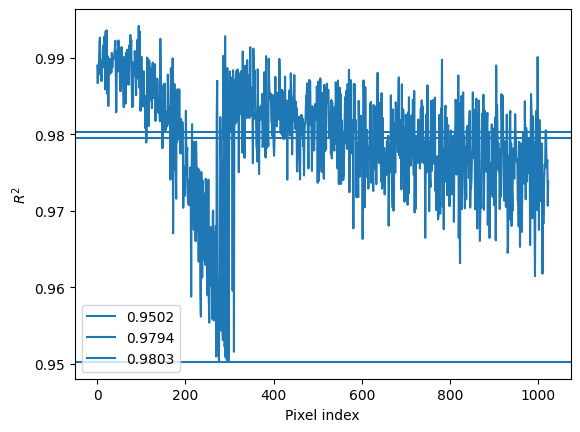

In [20]:
pixels = int(np.sqrt(len(odmr_measurements)))
image = np.zeros((pixels, pixels))
residuals = np.zeros(len(odmr_measurements))

fig, ax = plt.subplots()

for idx, odmr in enumerate(odmr_measurements.values()):
    row, col = odmr.xy_position
    if len(odmr.fit_model.params) == 6:
        splitting = 0
    else:
        splitting = np.abs(odmr.fit_model.best_values["l1_center"] - odmr.fit_model.best_values["l0_center"])  
        
    rsquared = odmr.fit_model.rsquared
    residuals[idx] = rsquared
    
    if rsquared < 0.95:
        image[row, col] = np.nan
    else:
        image[row, col] = splitting
        
print(np.shape(np.argwhere(np.isnan(image)))[0])

sns.lineplot(residuals, ax=ax)

ax.axhline(np.min(residuals), label=f"{np.min(residuals):.4f}")
ax.axhline(np.average(residuals), label=f"{np.average(residuals):.4f}")
ax.axhline(np.median(residuals), label=f"{np.median(residuals):.4f}")

ax.legend()

ax.set_xlabel("Pixel index")
ax.set_ylabel(r"$R^2$")

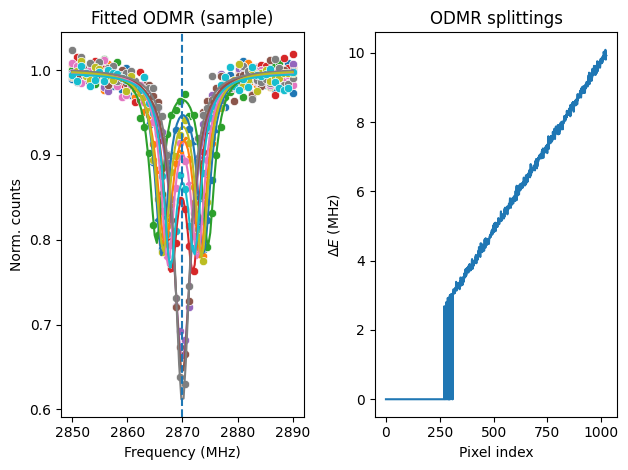

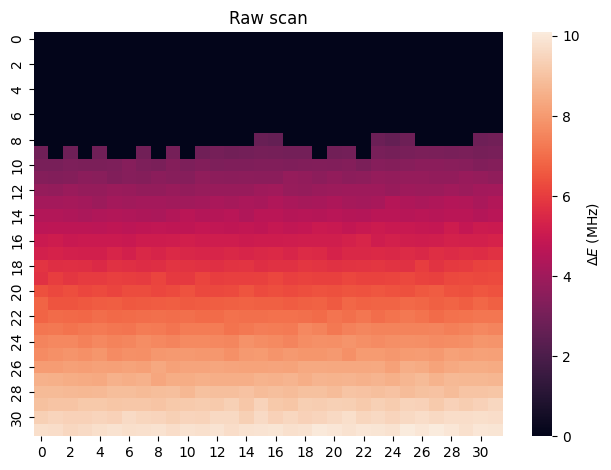

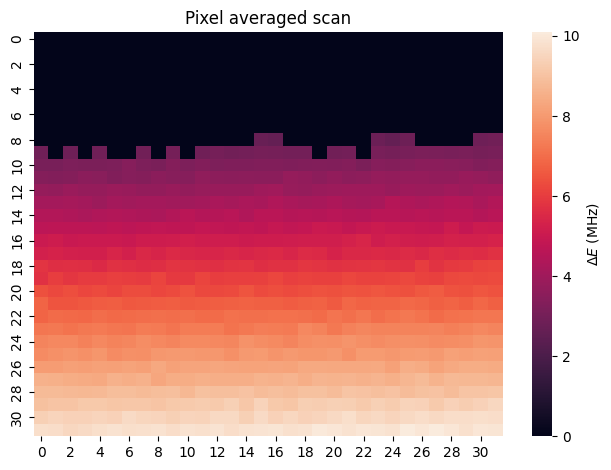

In [21]:
fig, (ax, ax1) = plt.subplots(ncols=2)

for _, odmr in random.sample(sorted(odmr_measurements.items()), k=10):
    sns.scatterplot(x="Freq(MHz)", y="Counts", data=odmr.data, ax=ax)
    sns.lineplot(x="x_fit", y="y_fit", data=odmr.fit_data, ax=ax)
    
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel("Norm. counts")
ax.axvline(2870, ls="--", label="ZFS")
ax.set_title(f"Fitted ODMR (sample)")

sns.lineplot(image.flatten(), ax=ax1)
ax1.set_xlabel("Pixel index")
ax1.set_ylabel(r"$\Delta E$ (MHz)")
ax1.set_title(f"ODMR splittings")

fig.tight_layout()
    
fig, ax = plt.subplots()
sns.heatmap(image, cbar_kws={"label": r"$\Delta E$ (MHz)"}, ax=ax)
ax.set_title("Raw scan")
fig.tight_layout()

fig, ax = plt.subplots()
sns.heatmap(dh.pixel_average_nan(image), cbar_kws={"label": r"$\Delta E$ (MHz)"}, ax=ax)
ax.set_title("Pixel averaged scan")
fig.tight_layout()